In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import torch.nn.functional as  F

In [3]:
words = open('/content/names.txt','r').read().splitlines()

In [4]:
chars = list(sorted(set(''.join(words))))
s2i = {s:i+1 for i ,s in enumerate(chars)}
s2i['<S>'] = 0
s2i['<E>'] = 27
i2s = {i:s for s,i in s2i.items()}

In [ ]:
N = torch.zeros((28,28,28), dtype=torch.int32)

for w in words:
  chr = ['<S>'] + list(w) + ['<E>']
  for ch1,ch2,ch3 in zip(chr,chr[1:], chr[2:]):
    ix1 = s2i[ch1]
    ix2 = s2i[ch2]
    ix3 = s2i[ch3]
    N[ix1,ix2,ix3] += 1
N

In [7]:
def inspect_N(ch1, ch2, ch3):
    # Returns how many times a given ch3 appears after a ch1, ch2 sequence.
    ix1 = s2i[ch1]
    ix2 = s2i[ch2]
    ix3 = s2i[ch3]
    print(f'At position ({ix1}, {ix2}, {ix3})')
    return N[ix1, ix2, ix3].item()

inspect_N('a','b','<E>')

At position (1, 2, 27)


36

In [8]:
P = (N+1).float()
P /= P.sum(dim=2, keepdim=True)
P.shape, P.sum(dim=2, keepdim=True).shape


(torch.Size([28, 28, 28]), torch.Size([28, 28, 1]))

In [9]:
g = torch.Generator().manual_seed(21437) # keeps the same 'randomness' generated

for i in range(10):
    ix1, ix2 = 0, 0
    out = []
    while True:

        p = P[ix1, ix2,:] # This can only happen (sampling from '.','.' sequence because we smoothed with (N+1).float()!!!!!)
        # Or else, this prob dist would all be 'nan' (i.e None), and it'd give us an error. Our assert above even checks for this! Damn, asserts op!

        ix1 = ix2 # Move our characters along
        ix2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(i2s[ix2])

        if ix2 == 27:
            break
    print(''.join(out))

pjeem<E>
pre<E>
q<S>braarryah<E>
won<E>
gitalandez<E>
dea<E>
qaxby<E>
aana<E>
pancyty<E>
paroni<E>


In [10]:
log_likelihood = 0.0
n = 0
for w in words:
    chs =  ['<S>'] + list(w) + ['<E>']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = s2i[ch1]
        ix2 = s2i[ch2]
        ix3 = s2i[ch3]

        prob = P[ix1, ix2, ix3] # get probability of ch3 appearing after ch1, ch2
        logprob = torch.log(prob)
        log_likelihood += logprob # Log likelihood, logprob range is -inf -> 0
        n +=1
        # print(f"{ch1}{ch2}: {prob:.4f}, {logprob:.4f}")

print(f'{log_likelihood=}')

nll = -log_likelihood # a very nice loss function -- lowest it gets is 0. Higher it is, worse off the predictions are
print(f'{nll=}') # summed nll
print(f'{nll/n=}')

log_likelihood=tensor(-410786.3750)
nll=tensor(410786.3750)
nll/n=tensor(2.0946)


In [11]:
# @title NN

# Create training set for trigram
def generate_training_set(words):
    """ Returns the xs, ys,"""
    xs, ys = [], [] # trigram labels. given xs, label ys. Ofc, we want these in integers so we convert char -> int below
    for w in words:
        chs = ['<S>'] + list(w) + ['<E>'] # Adding special token
        # print(list(zip(chs, chs[1:], chs[2:]))) # DON'T UNPRINT THIS WITHOUT CAPPING OFF THE WORDS to like words[:3]

        for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]): # zip makes 'emma' -> '(e,m),(m,m),(m,a)'.  Ofc we have special tokens too so it different.
            ix1 =   s2i[ch1]
            ix2 =   s2i[ch2]
            ixOut = s2i[ch3]
            xs.append((ix1, ix2))
            ys.append(ixOut)
            #print(xs)

    xs = torch.tensor(xs)
    ys = torch.tensor(ys)

    return xs, ys

xs, ys = generate_training_set(words[:1])
xs, xs.shape

(tensor([[ 0,  5],
         [ 5, 13],
         [13, 13],
         [13,  1]]),
 torch.Size([4, 2]))

In [12]:
xenc = F.one_hot(xs, num_classes=28)

In [13]:
xenc_flat = xenc.reshape(4,-1).float() # -1 will infer from the remaining dimensions so xenc(4,2,28)->xenc_flat(4,56) 2*28=56
xenc_flat, xenc_flat.shape


(tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.,

In [14]:
# initialise weights, make one forward pass through network (getting logits) and normalise it.
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((28*2, 28), generator=g, requires_grad=True) # Was (27,1) before for '1' neuron, but if you make it (27,27) it effectively evaluates all 27 neurons on all 5 inputs.

logits = xenc_flat @ W
# logits.shape
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
print(probs, probs.shape)
# Get loss too
loss = -probs[torch.arange(4), ys].log().mean()
loss

tensor([[0.0926, 0.0035, 0.0023, 0.0119, 0.0635, 0.0294, 0.0024, 0.0183, 0.0109,
         0.0345, 0.0060, 0.1306, 0.0118, 0.0072, 0.0157, 0.2064, 0.0586, 0.0018,
         0.0160, 0.0042, 0.0326, 0.0118, 0.0033, 0.0027, 0.0078, 0.1925, 0.0137,
         0.0081],
        [0.0890, 0.0099, 0.0252, 0.0026, 0.0067, 0.0640, 0.0200, 0.0014, 0.0149,
         0.0023, 0.0201, 0.0192, 0.0004, 0.2165, 0.0105, 0.0091, 0.0357, 0.0069,
         0.0013, 0.0382, 0.0423, 0.0251, 0.0364, 0.0057, 0.2466, 0.0176, 0.0222,
         0.0103],
        [0.0882, 0.0167, 0.0091, 0.0171, 0.0029, 0.0636, 0.0055, 0.0028, 0.0069,
         0.0030, 0.0139, 0.0852, 0.0043, 0.0321, 0.0924, 0.0043, 0.1504, 0.0065,
         0.0198, 0.0125, 0.2216, 0.0203, 0.0124, 0.0117, 0.0106, 0.0375, 0.0089,
         0.0398],
        [0.0365, 0.0358, 0.0052, 0.0102, 0.0083, 0.0379, 0.0215, 0.0075, 0.0037,
         0.0114, 0.0111, 0.0638, 0.0571, 0.0065, 0.2060, 0.0154, 0.2059, 0.0234,
         0.0470, 0.0038, 0.0016, 0.0133, 0.0127, 0.0147

tensor(3.2225, grad_fn=<NegBackward0>)

In [227]:
ys

tensor([13, 13,  1, 27])

In [228]:
probs[torch.arange(4), ys]

tensor([0.0072, 0.2165, 0.0167, 0.0971], grad_fn=<IndexBackward0>)

In [15]:
W.grad = None
loss.backward()

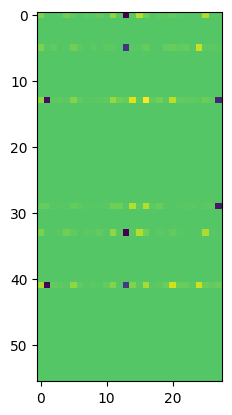

In [16]:
plt.imshow(W.grad)

In [17]:
xs, ys = generate_training_set(words)
xs.shape

torch.Size([196113, 2])

In [18]:
def train_trigram(xs, ys, epochs, lr, W=None) -> torch.tensor:

  if W == None:
    g = torch.Generator().manual_seed(2147483647)
    W = torch.randn((28*2, 28), generator=g, requires_grad=True)

  if xs.shape[1] != 56: # hard-coded
    xenc = F.one_hot(xs, num_classes=28)

    xenc_flat = xenc.reshape(len(xenc), -1).float()
  else:
    xenc_flat=xs

  num_examples = xs.shape[0]
  print(f"Number of examples: {num_examples}")
  for i in range(epochs):
    #xenc = F.one_hot(xs, num_classes=28)

    #xenc_flat = xenc.reshape(len(xenc), -1).float()
    #xenc_flat = xenc.reshape(xenc.shape[0], -1).float()

    # xenc_flat @ W -> (196113, 56) @ (56,28)

    #xenc_flat=xs
    # forward pass
    logits = xenc_flat @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(num_examples), ys].log().mean()

    print(f"Epoch: {i} || Loss: {loss}")
    # backward pass
    W.grad = None
    loss.backward()

    # Update weights
    W.data += -lr * W.grad

  return W, loss.item()

In [19]:
model_weights = None

In [20]:
model_weights, loss1 = train_trigram(xs, ys, 100, 50, W=model_weights)

Number of examples: 196113
Epoch: 0 || Loss: 3.98872971534729
Epoch: 1 || Loss: 3.2773752212524414
Epoch: 2 || Loss: 3.016171455383301
Epoch: 3 || Loss: 2.8558714389801025
Epoch: 4 || Loss: 2.7481861114501953
Epoch: 5 || Loss: 2.672719717025757
Epoch: 6 || Loss: 2.6172494888305664
Epoch: 7 || Loss: 2.5745604038238525
Epoch: 8 || Loss: 2.5404233932495117
Epoch: 9 || Loss: 2.5124261379241943
Epoch: 10 || Loss: 2.4890310764312744
Epoch: 11 || Loss: 2.4692015647888184
Epoch: 12 || Loss: 2.452179431915283
Epoch: 13 || Loss: 2.4374027252197266
Epoch: 14 || Loss: 2.4244420528411865
Epoch: 15 || Loss: 2.4129743576049805
Epoch: 16 || Loss: 2.40274977684021
Epoch: 17 || Loss: 2.3935773372650146
Epoch: 18 || Loss: 2.3853046894073486
Epoch: 19 || Loss: 2.3778107166290283
Epoch: 20 || Loss: 2.3709945678710938
Epoch: 21 || Loss: 2.3647735118865967
Epoch: 22 || Loss: 2.3590757846832275
Epoch: 23 || Loss: 2.353841543197632
Epoch: 24 || Loss: 2.3490183353424072
Epoch: 25 || Loss: 2.3445613384246826
Epo

In [21]:
loss1, model_weights

(2.2631661891937256,
 tensor([[-1.2466,  2.4377,  0.3382,  ...,  1.1777,  0.8345, -2.8816],
         [-2.1990,  0.2891, -0.2941,  ...,  0.1136, -0.2438,  1.2529],
         [-0.0710,  1.2343, -0.5666,  ...,  0.8655, -0.4992,  0.4010],
         ...,
         [-1.7487,  1.9788, -0.5849,  ..., -1.5469, -0.1231,  1.5139],
         [-1.0931,  2.2689, -0.0277,  ...,  1.2078, -0.0431,  0.3370],
         [-0.0811,  0.4353, -0.0897,  ...,  1.5992,  1.1401,  0.9196]],
        requires_grad=True))

In [22]:
#xenc = F.one_hot(xs, num_classes=28).float()
trial = torch.tensor([0,3])
xenc = F.one_hot(trial, num_classes=28).float()
xenc_flat = xenc.reshape((1, -1))
trial.shape, xenc.shape, len(xenc), xenc_flat.shape, model_weights.shape


(torch.Size([2]),
 torch.Size([2, 28]),
 2,
 torch.Size([1, 56]),
 torch.Size([56, 28]))

In [23]:
def generate_random_names(num_names: int, weights) -> None:
  g = torch.Generator().manual_seed(2147483647)

  for i in range(20):
    name = []
    ix1 = 0
    ix2 = 0
    while True:
      xenc = F.one_hot(torch.tensor([ix1,ix2]), num_classes=28).float()
      # here we are taking a random sample as input, to see how well the trained weights can model random inputs
      # torch.tensor([ix1,ix2]) corresponds to feeding just 1 example data
      # so xenc_flat-> (1, 56) -> (one example, flat_ch1&ch2)
      xenc_flat = xenc.reshape((1, -1))

      logits = xenc_flat @ weights
      counts = logits.exp()
      probs = counts / counts.sum(dim=1,keepdim=True)


      ix1 = ix2
      ix2 = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
      name.append(i2s[ix2])
      if ix2 == 27:
                break

    print(''.join(name))
  print(f"probs: {probs}, shape: {probs.shape}")

In [24]:
generate_random_names(5, model_weights)

aunide<E>
ia<E>
asa<E>
aush<E>
ay<E>
ainn<E>
guith<E>
tole<E>
amare<E>
zusann<E>
auvin<E>
adviassib<E>
ain<E>
wi<E>
ca<E>
seisie<E>
yla<E>
telin<E>
aumer<E>
fontumer<E>
probs: tensor([[0.0012, 0.1266, 0.0035, 0.0087, 0.0148, 0.0773, 0.0020, 0.0214, 0.0116,
         0.1785, 0.0022, 0.0072, 0.0510, 0.0225, 0.0125, 0.0508, 0.0028, 0.0016,
         0.0383, 0.0245, 0.0288, 0.0099, 0.0059, 0.0018, 0.0017, 0.0503, 0.0052,
         0.2373]], grad_fn=<DivBackward0>), shape: torch.Size([1, 28])


## EXERCISE 2

In [25]:
from torch.utils.data import random_split

In [169]:
train_subset, test_subset, valid_subset = random_split(range(100), [0.8, 0.1, 0.1])

In [170]:
len(words),len(train_subset),len(test_subset),len(valid_subset)

(32033, 80, 10, 10)

In [26]:
xs, ys = generate_training_set(words)
xenc = F.one_hot(xs, num_classes=28).float()
xenc_flat = xenc.reshape((xenc.shape[0], -1))
xs.shape, xenc.shape, xenc_flat.shape

(torch.Size([196113, 2]),
 torch.Size([196113, 2, 28]),
 torch.Size([196113, 56]))

In [195]:
ys.shape

torch.Size([196113])

In [27]:
total_enc_data = xenc_flat.shape[0]
print("Range of encoded x (i.e number of examples):", range(total_enc_data))

Range of encoded x (i.e number of examples): range(0, 196113)


In [28]:
train_subset, test_subset, valid_subset = random_split(range(total_enc_data), [0.8, 0.1, 0.1])

In [29]:
train_idx = torch.tensor(train_subset)
test_idx = torch.tensor(test_subset)
val_idx = torch.tensor(valid_subset)

In [30]:
train_idx.shape, test_idx.shape, val_idx.shape

(torch.Size([156891]), torch.Size([19611]), torch.Size([19611]))

In [31]:
x_train, y_train = xenc_flat[train_idx], ys[train_idx]
x_test, y_test = xenc_flat[test_idx], ys[test_idx]
x_val, y_val = xenc_flat[val_idx], ys[val_idx]

In [245]:
x_train.shape,y_train.shape

(torch.Size([156891, 56]), torch.Size([156891]))

In [32]:
model2_weights, loss2 = train_trigram(x_train, y_train, 100, 50)

Number of examples: 156891
Epoch: 0 || Loss: 3.9879350662231445
Epoch: 1 || Loss: 3.2792294025421143
Epoch: 2 || Loss: 3.0186843872070312
Epoch: 3 || Loss: 2.8586647510528564
Epoch: 4 || Loss: 2.751077890396118
Epoch: 5 || Loss: 2.6755943298339844
Epoch: 6 || Loss: 2.6200814247131348
Epoch: 7 || Loss: 2.57735538482666
Epoch: 8 || Loss: 2.5431878566741943
Epoch: 9 || Loss: 2.5151560306549072
Epoch: 10 || Loss: 2.4917211532592773
Epoch: 11 || Loss: 2.4718470573425293
Epoch: 12 || Loss: 2.4547784328460693
Epoch: 13 || Loss: 2.4399564266204834
Epoch: 14 || Loss: 2.426954507827759
Epoch: 15 || Loss: 2.4154489040374756
Epoch: 16 || Loss: 2.405191421508789
Epoch: 17 || Loss: 2.3959903717041016
Epoch: 18 || Loss: 2.3876941204071045
Epoch: 19 || Loss: 2.3801801204681396
Epoch: 20 || Loss: 2.373347282409668
Epoch: 21 || Loss: 2.367111921310425
Epoch: 22 || Loss: 2.3614022731781006
Epoch: 23 || Loss: 2.356156826019287
Epoch: 24 || Loss: 2.3513238430023193
Epoch: 25 || Loss: 2.3468568325042725
Epo

In [33]:
x_train.shape

torch.Size([156891, 56])

In [34]:
def evaluate_model(xs, ys, W):
  logits = xs @ W
  counts = logits.exp()
  probs = counts / counts.sum(dim=1,keepdim=True)
  loss = -probs[torch.arange(x_val.shape[0]), ys].log().mean()
  return loss

In [35]:
val_loss = evaluate_model(x_val,y_val, model2_weights)
test_loss = evaluate_model(x_test,y_test, model2_weights)
print(f"Val Loss: {val_loss} || Test Loss: {test_loss}")

Val Loss: 2.2463879585266113 || Test Loss: 2.2682180404663086


In [36]:
generate_random_names(5, model2_weights)

aunide<E>
ia<E>
asa<E>
aush<E>
ay<E>
ainn<E>
guith<E>
tole<E>
amare<E>
zusann<E>
aur<E>
ailen<E>
assib<E>
ain<E>
wi<E>
ca<E>
seisie<E>
yla<E>
telin<E>
aumer<E>
probs: tensor([[0.0012, 0.1253, 0.0033, 0.0095, 0.0166, 0.0770, 0.0020, 0.0221, 0.0112,
         0.1746, 0.0021, 0.0067, 0.0528, 0.0251, 0.0131, 0.0510, 0.0028, 0.0014,
         0.0383, 0.0251, 0.0287, 0.0095, 0.0064, 0.0018, 0.0016, 0.0479, 0.0051,
         0.2378]], grad_fn=<DivBackward0>), shape: torch.Size([1, 28])


In [37]:
def train_trigram_with_reg(xs, ys, epochs, lr:float, reg:float, W=None) -> torch.tensor:

  if W == None:
    g = torch.Generator().manual_seed(2147483647)
    W = torch.randn((28*2, 28), generator=g, requires_grad=True)

  if xs.shape[1] != 56: # hard-coded
    xenc = F.one_hot(xs, num_classes=28)

    xenc_flat = xenc.reshape(len(xenc), -1).float()
  else:
    xenc_flat=xs

  num_examples = xs.shape[0]
  loss_list = []
  print(f"Number of examples: {num_examples}")
  for i in range(epochs):
    #xenc = F.one_hot(xs, num_classes=28)

    #xenc_flat = xenc.reshape(len(xenc), -1).float()
    #xenc_flat = xenc.reshape(xenc.shape[0], -1).float()

    # xenc_flat @ W -> (196113, 56) @ (56,28)

    #xenc_flat=xs
    # forward pass
    logits = xenc_flat @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(num_examples), ys].log().mean() + reg * (W**2).mean()

    loss_list.append(loss.item())
    print(f"Epoch: {i} || Loss: {loss}")

    # backward pass
    W.grad = None
    loss.backward()

    # Update weights
    W.data += -lr * W.grad

  plot_loss(range(1,epochs+1) ,loss_list , reg, lr)

  return W, loss.item()

In [ ]:
model_reg_W, loss3 = train_trigram_with_reg(xenc_flat,ys, 100, 50, 0.1)

In [ ]:
reg = [0.01, 0.05, 0.1, 0.2, 0.5]
for i in range(len(reg)):
  model_reg_W, loss3 = train_trigram_with_reg(xenc_flat,ys, 50, 50, reg[i])
  print(loss3)

In [282]:
loss1, loss2, loss3

(2.2631661891937256, 2.260226011276245, 2.329425573348999)

In [38]:
def plot_loss(epoch, loss, reg=None, lr=None):
  plt.figure(figsize=(12,8))
  plt.plot(epoch, loss)
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.title(f"Loss vs Epoch for reg: {reg} and lr: {lr}")

## EXERCISE 4
we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?<br>


Neat Indexing trick:
```
g = torch.Generator().manual_seed(2147483647)
ww = torch.randn((28*2,28), generator=g,requires_grad=True)
ww1 = W[:28]
ww2 = W[28:]
wq1 = ww1[xs[:,0]] + ww2[xs[:,1]]
ww1.shape, ww2.shape

xs[:,0][:5]
ww1[xs[:,0][:5]] , ww2[xs[:,0][:5]]
```
ww1[xs[:,0]]-> (196113, 28) ww2[xs[:,1]]->(196113, 28)
ww1 are weights of the 1st char of all the examples
ww2 are weights of the 2nd char of all the examples

now ww1[xs[:,0]] + ww2[xs[:,1]] will mean all characters weights are added in accordance to their context

e.g.    [[ 0,  5], <br>
        [ 5, 13],<br>
        [13, 13],<br>
        ...,<br>
        [26, 25],<br>
        [25, 26],<br>
        [26, 24]] <br><br>
[0,5]-> '0' 1st char, '5' 2nd char and we do ww1(for'0') + ww2(for'5')


In [100]:
xs, ys = generate_training_set(words)

In [114]:
def train_trigram_reg_idx(xs, ys, epochs:int, lr=50, reg=0, W=None):

  if W == None:
    g = torch.Generator().manual_seed(2147483647)
    W = torch.randn((28*2,28), generator=g,requires_grad=True)

  num_ex =  xs.shape[0]
  print(f"Num of Example: {num_ex}")

  for i in range(epochs):
    # forward
    ww1 = W[:28] # (28,28)
    ww2 = W[28:]  # (28,28)
    logits = ww1[xs[:,0]] + ww2[xs[:,1]]  # [196113, 28] + [196113, 28]
    counts = logits.exp()
    probs = counts/counts.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(num_ex), ys].log().mean() + reg * (W**2).mean()
    print(f'Epoch {i}. Loss: {loss.item():.4f}')

    # backward
    W.grad = None
    loss.backward()

    # update
    W.data += -lr * W.grad

  return W



In [110]:
x_train, y_train = xs[train_idx], ys[train_idx]
x_val, y_val = xs[val_idx], ys[val_idx]
x_test, y_test = xs[test_idx], ys[test_idx]

In [ ]:
model = train_trigram_reg_idx(x_train, y_train, 100, 50)

In [117]:
def evaluate_loss_idx(W, x, y):
  W1 = W[:28]
  W2 = W[28:]
  logits = W1[x[:,0]] + W2[x[:,1]]
  counts = logits.exp()
  prob = counts/counts.sum(1, keepdims=True)
  return -prob[torch.arange(x.shape[0]), y].log().mean()

In [118]:
evaluate_loss_idx(model, x_val, y_val)

tensor(2.2464, grad_fn=<NegBackward0>)

In [119]:
evaluate_loss_idx(model, x_test, y_test)

tensor(2.2682, grad_fn=<NegBackward0>)


##E05:

look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?
